In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
# Import normalization modules
from sklearn.preprocessing import MinMaxScaler
# Import Dimensionality Reduction Modules
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
# Import machine learning libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import OneClassSVM
from sklearn.naive_bayes import GaussianNB
# Import graphviz to visualize decision tree
import graphviz
from sklearn.tree import export_graphviz
from graphviz import Source
# Import model selection module
from sklearn.model_selection import GridSearchCV
# Import the evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

# Import the visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import time
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
credit_info = pd.read_csv("creditcard.csv")

In [3]:
# Shuffle data
credit_info_shuffled = credit_info.sample(frac=1)
# one-hot encode the target variable
#credit_info_encoded = pd.get_dummies(credit_info_shuffled, columns=["Class"])

# Splitting the data into train and test
training_size = int(0.8 * len(credit_info_shuffled))
Training_set = credit_info_shuffled.iloc[:training_size, :]
Test_set = credit_info_shuffled.iloc[training_size:, :]
# Separate out the input variables and the target variables
X_train = Training_set.iloc[:, :-1]
y_train = Training_set.iloc[:, -1]
X_test = Test_set.iloc[:, :-1]
y_test = Test_set.iloc[:, -1]
# min-max normalize the data using MinMaxScaler
normalizer = MinMaxScaler()
X_train_scaled = normalizer.fit_transform(X_train)
X_test_scaled = normalizer.transform(X_test)

# Come up with the fraud weighting
fraud_ratio = len(credit_info[credit_info["Class"] == 1]) / len(credit_info)
fraud_weight = 1/ fraud_ratio * 1.2

In [4]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

In [5]:
y_train.value_counts()/len(y_train)

0    0.998297
1    0.001703
Name: Class, dtype: float64

In [6]:
y_test.value_counts()/len(y_test)

0    0.998174
1    0.001826
Name: Class, dtype: float64

In [7]:
# set the index of y_train and y_test to have them match with X_train_scaled and X_test_scaled
y_train.index = X_train_scaled.index
y_test.index = X_test_scaled.index

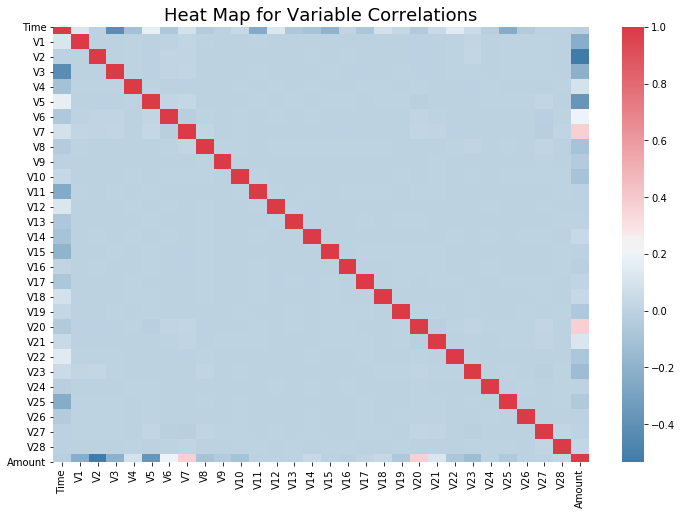

In [8]:
plt.subplots(figsize=(12,8))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(X_train_scaled.corr(), cmap = cmap)
plt.title("Heat Map for Variable Correlations", size = 18)
plt.show()

In [9]:
# Let's graph the clustering structure of the datapoints
# Because there are around 30 variables, I will use PCA to reduce dimensionality first before graphing it
pca = PCA(n_components=2, random_state=0)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
positive_case_index_train = y_train[y_train==1].index
negative_case_index_train = y_train[y_train==0].index
positive_case_index_test = y_test[y_test==1].index
negative_case_index_test = y_test[y_test==0].index

In [10]:
pd.DataFrame(X_train_pca, columns=["Component 1", "Component 2"])

,Component 1,Component 2
0,0.335197,0.075720
1,0.184871,0.143418
2,-0.271010,-0.001797
3,0.420216,-0.071318
4,0.236418,0.125190
...,...,...
227840,-0.208167,-0.181451
227841,-0.149565,0.073796
227842,0.315062,0.022740
227843,-0.158370,-0.019905


In [11]:
def visualize_points_scatter(data, negative_index, positive_index, x_var, y_var, title_addon = None):
    plt.subplots(figsize=(12,8))
    plt.scatter(x = data.loc[negative_index, x_var],
                y = data.loc[negative_index, y_var], label = "Normal Cases", s=12, c="b")
    plt.scatter(x = data.loc[positive_index, x_var], 
                y = data.loc[positive_index, y_var], label = "Fraud Cases", s=12, c="r")
    plt.legend()
    plt.xlabel(x_var, size = 15)
    plt.ylabel(y_var, size = 15)
    plt.title("Distribution for Credit Card Fraud Cases {}".format(title_addon), size = 18)
    plt.show()

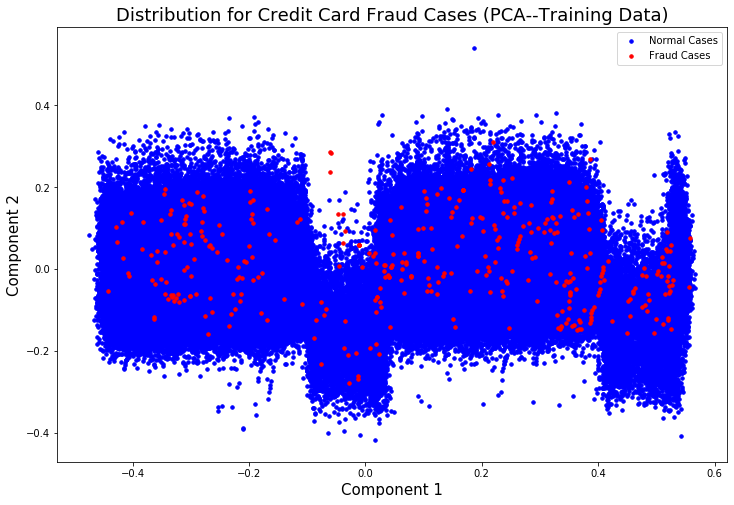

In [12]:
visualize_points_scatter(pd.DataFrame(X_train_pca, columns=["Component 1", "Component 2"]), 
                         negative_case_index_train, positive_case_index_train, "Component 1", "Component 2",
                        title_addon = "(PCA--Training Data)")

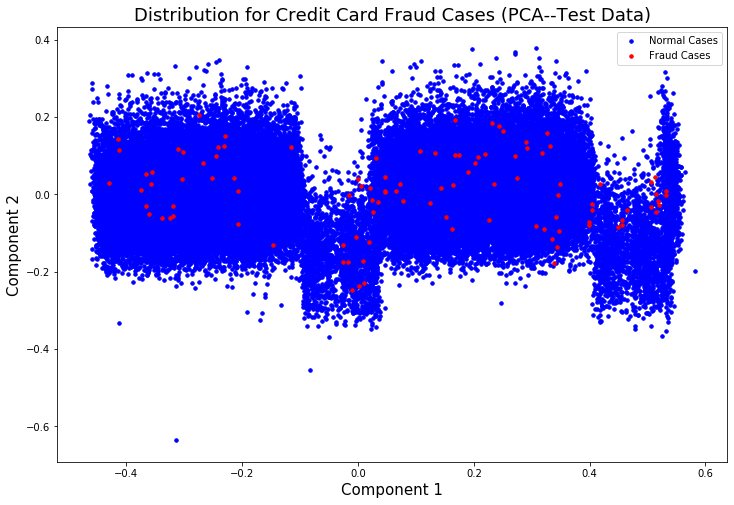

In [13]:
visualize_points_scatter(pd.DataFrame(X_test_pca, columns=["Component 1", "Component 2"]), 
                         negative_case_index_test, positive_case_index_test, "Component 1", "Component 2",
                        title_addon = "(PCA--Test Data)")

It seems that just using PCA method cannot achieve a good separation between normal cases and fraud cases

In [14]:
pd.DataFrame(X_train_pca)

,0,1
0,0.335197,0.075720
1,0.184871,0.143418
2,-0.271010,-0.001797
3,0.420216,-0.071318
4,0.236418,0.125190
...,...,...
227840,-0.208167,-0.181451
227841,-0.149565,0.073796
227842,0.315062,0.022740
227843,-0.158370,-0.019905


In [15]:
# Let's show again how each variables are correlated to the target variable
# I will take the absolute value of the pearson correlation coefficient 
variable_to_target_correlations = []
for var in X_train_scaled.columns:
    variable_to_target_correlations.append(abs(pearsonr(X_train_scaled.loc[:,var], y_train)[0]))

In [16]:
var_to_target_cor = pd.Series(variable_to_target_correlations, index=X_train_scaled.columns).sort_values(ascending=False)

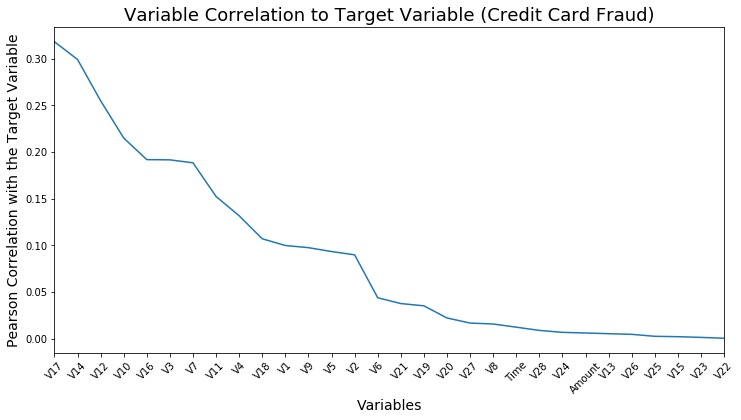

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
pd.Series(var_to_target_cor).sort_values(ascending=False).plot()
ax.set_xticks(range(len(var_to_target_cor)))
ax.set_xticklabels([item for item in var_to_target_cor.index.tolist()], rotation=45)
plt.title("Variable Correlation to Target Variable (Credit Card Fraud)", size=18)
ax.set_ylabel("Pearson Correlation with the Target Variable", size = 14)
ax.set_xlabel("Variables", size = 14)
plt.show()

Some of the variables are weakly correlated with each other, but none are strongly correlated with the target variables

In [18]:
# Let's use random forest to get some ideas about feature importance
rf = RandomForestClassifier(random_state = 0, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [19]:
feature_importance = pd.Series(rf.feature_importances_, index=X_train.columns)

In [20]:
feature_importance.sort_values(ascending=False)

V14       0.138051
V12       0.126299
V17       0.125072
V10       0.107304
V16       0.073658
V11       0.066782
V9        0.042215
V18       0.027800
V7        0.025902
V4        0.022970
V26       0.019045
V21       0.017559
V3        0.016026
V6        0.015425
V5        0.015077
V1        0.012962
V19       0.012348
Time      0.012311
V8        0.012007
V20       0.011973
Amount    0.011910
V2        0.011212
V27       0.011024
V28       0.010633
V15       0.010225
V13       0.010083
V25       0.009020
V22       0.008677
V23       0.008348
V24       0.008084
dtype: float64

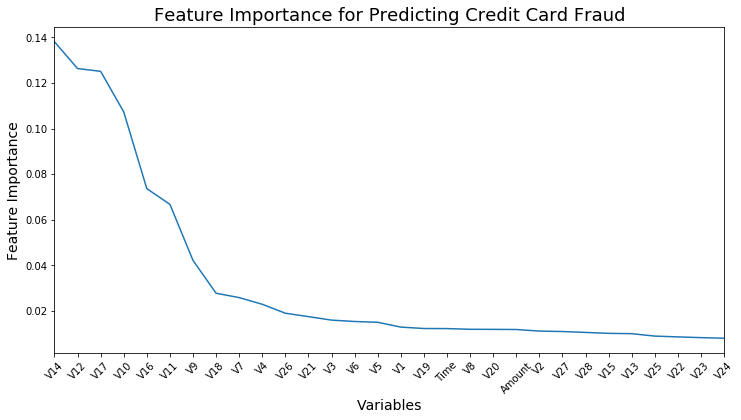

In [21]:
fig, ax = plt.subplots(figsize=(12,6))
pd.Series(feature_importance).sort_values(ascending=False).plot()
ax.set_xticks(range(len(feature_importance)))
ax.set_xticklabels([item for item in feature_importance.sort_values(ascending=False).index.tolist()], rotation=45)
plt.title("Feature Importance for Predicting Credit Card Fraud", size=18)
ax.set_ylabel("Feature Importance", size = 14)
ax.set_xlabel("Variables", size = 14)
plt.show()

V12, V17, V14, V10, V16, V11 and V9 appear to be more useful in predicting the target values


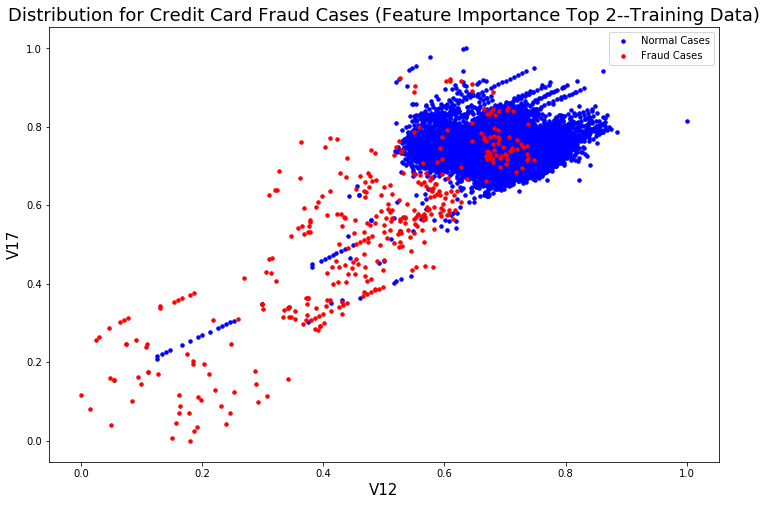

In [22]:
# Let's see if we can achieve a better separation of normal and fraud cases using variable V12 and V17
visualize_points_scatter(X_train_scaled, negative_case_index_train, positive_case_index_train, "V12", "V17",
                        title_addon = "(Feature Importance Top 2--Training Data)")

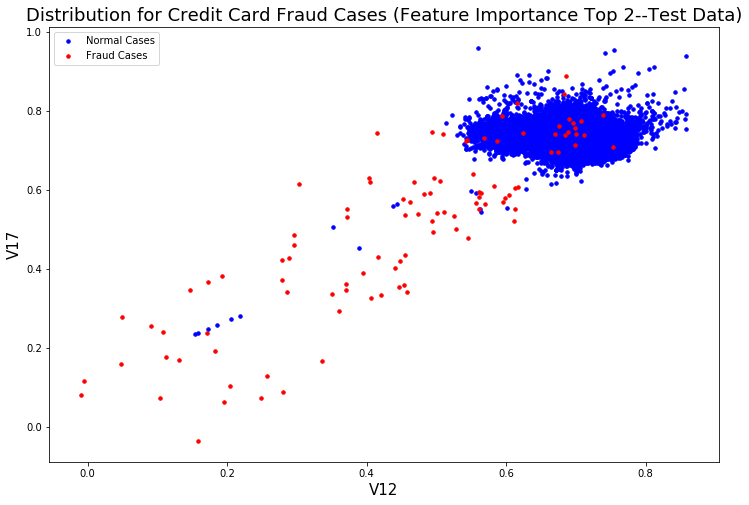

In [23]:
# Let's repeat the process on the testing data
visualize_points_scatter(X_test_scaled, negative_case_index_test, positive_case_index_test, "V12", "V17",
                        title_addon = "(Feature Importance Top 2--Test Data)")

There are still some overlap between the fraud cases clusters and normal cases clusters, but it is more apparent that fraud cases have smaller V12 and V17 than normal cases do

**This prompts us to ask: What would the scatter plot look if the two PCA components are from  these important features**

In [24]:
# Let's graph the clustering structure of the datapoints
# I will use PCA to reduce dimensionality of the 7 important feature variables before graphing it
important_features = ["V12", "V17", "V14", "V10", "V16", "V11", "V9"] # store important features in a list
pca = PCA(n_components=2, random_state=0)
X_train_small_pca = pca.fit_transform(X_train_scaled[important_features])
X_test_small_pca = pca.transform(X_test_scaled[important_features])
positive_case_index_train = y_train[y_train==1].index
negative_case_index_train = y_train[y_train==0].index
positive_case_index_test = y_test[y_test==1].index
negative_case_index_test = y_test[y_test==0].index

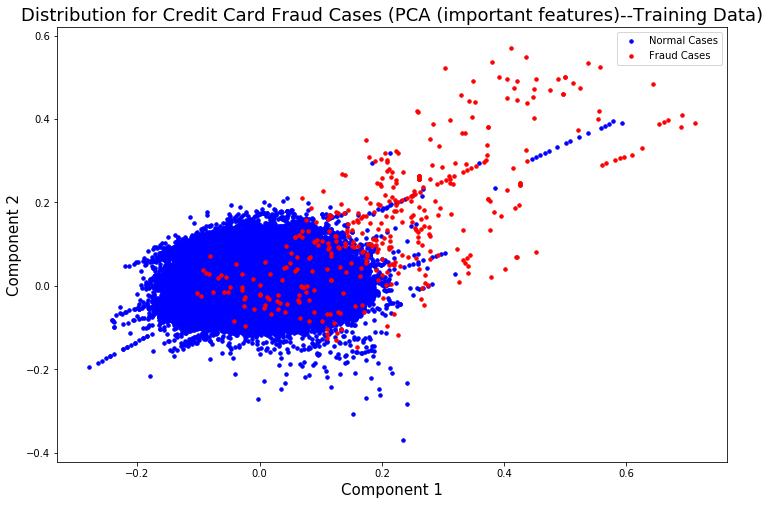

In [25]:
visualize_points_scatter(pd.DataFrame(X_train_small_pca, columns=["Component 1", "Component 2"]), 
                         negative_case_index_train, positive_case_index_train, "Component 1", "Component 2",
                        title_addon = "(PCA (important features)--Training Data)")

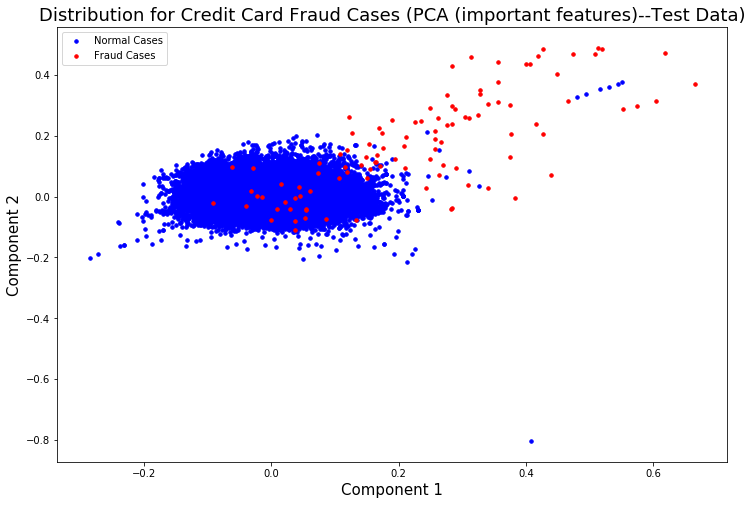

In [26]:
visualize_points_scatter(pd.DataFrame(X_test_small_pca, columns=["Component 1", "Component 2"]), 
                         negative_case_index_test, positive_case_index_test, "Component 1", "Component 2",
                        title_addon = "(PCA (important features)--Test Data)")

In [27]:
# Let's evaluate the accuracy, precision, and recall scores of the random forest model
y_pred = rf.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)

print("Accuracy Score for the rf model is: {}".format(rf_accuracy))
print("Precision Score for the rf model is: {}".format(rf_precision))
print("Recall Score for the rf model is: {}".format(rf_recall))

Accuracy Score for the rf model is: 0.9995962220427653
Precision Score for the rf model is: 0.9879518072289156
Recall Score for the rf model is: 0.7884615384615384


In [28]:
rf_weighted = RandomForestClassifier(random_state = 0, class_weight = {0:1, 1:fraud_weight}, n_jobs = -1)
rf_weighted.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 694.6512195121951},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [29]:
y_pred = rf_weighted.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)

print("Accuracy Score for the rf_weighted model is: {}".format(rf_accuracy))
print("Precision Score for the rf_weighted model is: {}".format(rf_precision))
print("Recall Score for the rf_weighted model is: {}".format(rf_recall))

Accuracy Score for the rf_weighted model is: 0.9995259997893332
Precision Score for the rf_weighted model is: 1.0
Recall Score for the rf_weighted model is: 0.7403846153846154


By increasing the weighting on the fraud cases, it has increased the precision but decreased the recall

In [30]:
# Right now the Random Forest predicts a case to be fraud if the fraud probability is above 0.5. 
# We can change that threshold to either lower or higher to see how it impacts performances
y_pred_proba = rf_weighted.predict_proba(X_test_scaled)

In [31]:
# Let's create a plot that shows how accuracy, precision, and recall scores change when predict threshold changes
def making_prediction(pred_proba, threshold):
    pred = []
    for p in pred_proba[:,1]:
            if p >= threshold:
                pred.append(1)
            else:
                pred.append(0)
    return np.asarray(pred)

def evaluate_score_distribution(pred_proba, test, model_name, save_fig = False, figname = None): 
    # pred_proba is the result of model.predict_proba
    accuracy_score_dist = {}
    precision_score_dist = {}
    recall_score_dist = {}
    
    threshold_range = np.arange(0, 1 + 0.01, 0.01)
    for threshold in threshold_range:
        pred = making_prediction(pred_proba, threshold) # Use the making_prediction function we just created
        # calculating the metrics for this prediction 
        accuracy = accuracy_score(test, pred)
        precision = precision_score(test, pred)
        recall = recall_score(test, pred)
        
        
        accuracy_score_dist[threshold] = accuracy
        precision_score_dist[threshold] = precision
        recall_score_dist[threshold] = recall
        
        
        
    # Plot the evaluation scores distribution
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(pd.Series(accuracy_score_dist), label="Accuracy Distribution")
    ax.plot(pd.Series(precision_score_dist), label="Precision Distribution")
    ax.plot(pd.Series(recall_score_dist), label="Recall Distribution")
    plt.xticks(threshold_range[::5])
    plt.yticks(np.arange(0, 1 + 0.1, 0.1))
    plt.xlabel("Prediction Probability Threshold", size = 15)
    plt.ylabel("Evaluation Scores", size = 15)
    plt.grid(axis="both")
    plt.legend(loc="lower right")
    plt.title("Evaluation Metrics Distribution ({})".format(model_name), size=18)
    if save_fig == True:
        plt.savefig(figname)
    plt.show()

    
    

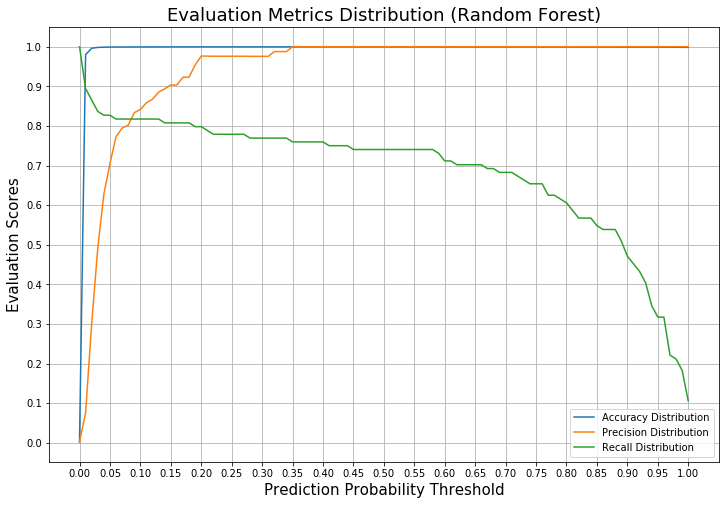

In [32]:
evaluate_score_distribution(y_pred_proba, y_test, "Random Forest", True, "Random_Forest_eval_dist.png")

It seems that if we lower the prediction probability threshold from the default 50 percent to 15 percent, we can achieve much higher recall score while maintaining a precision score of arounf 85%


In [33]:
def create_roc_curve(model, X_test, y_test, model_name, save_fig = False, figname = None):
    y_score = rf_weighted.predict_proba(X_test_scaled)[:, 1]

    bl_probs = [0 for a in range(len(y_test))]

    bl_fpr, bl_tpr, _ = roc_curve(y_test, bl_probs)
    rf_fpr, rf_tpr, _ = roc_curve(y_test, y_score)

    plt.subplots(figsize = (12, 8))
    plt.plot(bl_fpr, bl_tpr, label = "Baseline")
    plt.plot(rf_fpr, rf_tpr, linestyle="--", label = model_name)
    plt.xlabel("False Positive Rate", size=14)
    plt.ylabel("True Positive Rate", size=14)
    plt.title("ROC Curve for the {} in Predicting Credit Card Fraud".format(model_name), size = 18)
    plt.legend()
    if save_fig == True:
        plt.savefig(figname)
    plt.show()



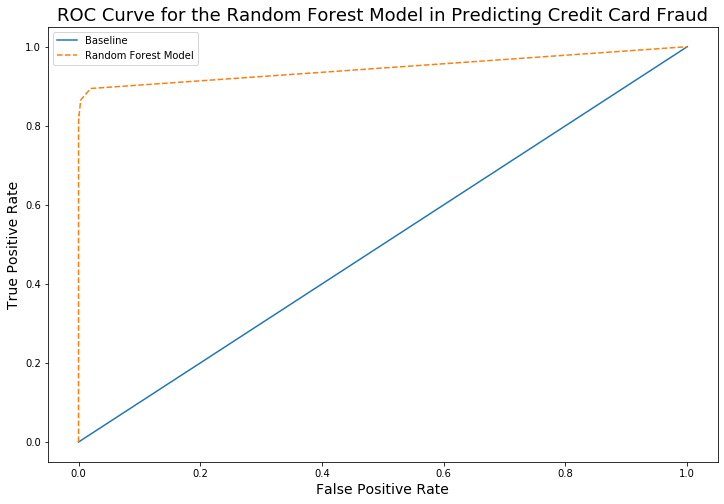

In [34]:
create_roc_curve(rf_weighted, X_test_scaled, y_test, "Random Forest Model")

In [35]:
# Let's first see the confusion matrix of the default model with 50 percent prediction threshold
confusion_matrix(y_test, y_pred)

array([[56858,     0],
       [   27,    77]], dtype=int64)

In [36]:
# Let's now see the confusion matrix of the new model with 15 percent prediction threshold
y_pred_15 = making_prediction(y_pred_proba, 0.15)
confusion_matrix(y_test, y_pred_15)

array([[56849,     9],
       [   20,    84]], dtype=int64)

### Now let's try other models to see if they can perform even better

## Let's now look at the Decision Tree Model

In [37]:
dt = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 2, random_state = 0, class_weight = {0:1, 1:fraud_weight})
dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 1, 1: 694.6512195121951},
                       criterion='gini', max_depth=10, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=0, splitter='best')

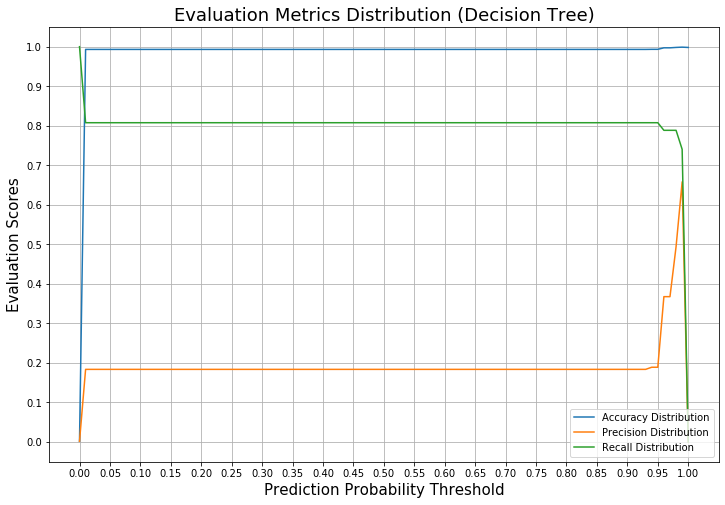

In [38]:
y_pred_proba_dt = dt.predict_proba(X_test_scaled)
evaluate_score_distribution(y_pred_proba_dt, y_test, "Decision Tree")

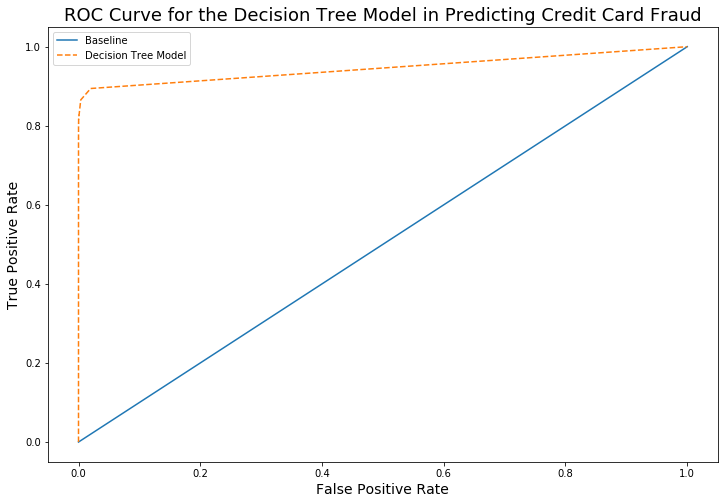

In [39]:
create_roc_curve(dt, X_test_scaled, y_test, "Decision Tree Model")

In [40]:
# Let's visualize the decision tree
export_graphviz(dt, out_file = "tree_conversion.dot", feature_names=X_train_scaled.columns, 
                proportion = True, rotate = True)
with open("tree_conversion.dot") as f:
    dot_graph = f.read()
    
s = Source.from_file("tree_conversion.dot")
s.view()

'tree_conversion.dot.pdf'

Decision Tree doesn't seem to be able to predict credit card fraud well. Within tree depth of 10, the model can only identify around 10 percent of the fraud cases

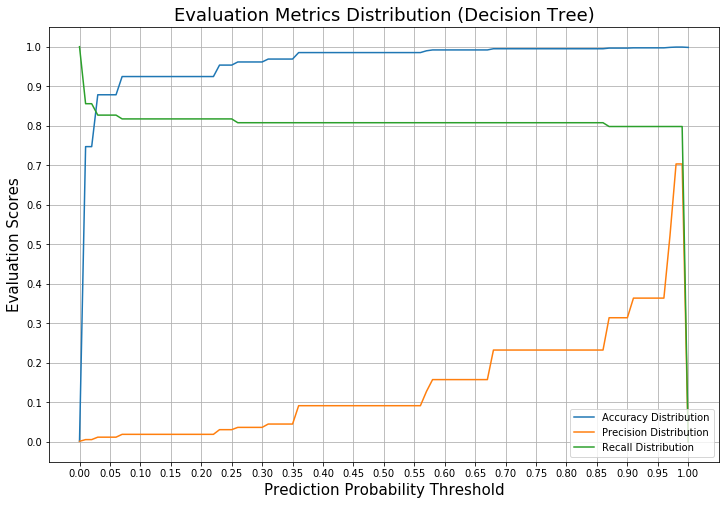

In [41]:
# Let's see if the prediction result will get better if we only use the most importance features from feature importance 
important_features = ["V12", "V17", "V14", "V10", "V16", "V11", "V9"]
dt.fit(X_train_scaled[important_features], y_train)
y_pred_proba_dt_small = dt.predict_proba(X_test_scaled[important_features])
evaluate_score_distribution(y_pred_proba_dt_small, y_test, "Decision Tree")

The result is still very unsatisfactory. If we set the threshold to almost 99 percent, we will get 67 percent of precision and 67 percent of recall. This is not very good

***This seems to show that overall, random forest is a better model in terms predicting credit card fraud cases***

## From the previous distribution plots, we can see that even with two variables, we can see that fraud cases form a distinct cluster that's divergent from normal cases. May be we should pay attention to algorithms that try to form clusters

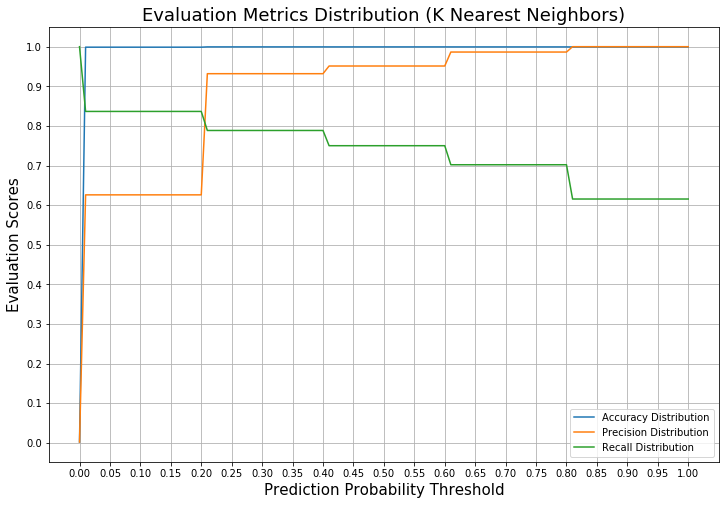

In [42]:
# Let's first try KNN model
knn = KNeighborsClassifier(n_jobs = -1)
knn.fit(X_train_scaled, y_train)
y_pred_proba_knn = knn.predict_proba(X_test_scaled)
evaluate_score_distribution(y_pred_proba_knn, y_test, "K Nearest Neighbors")

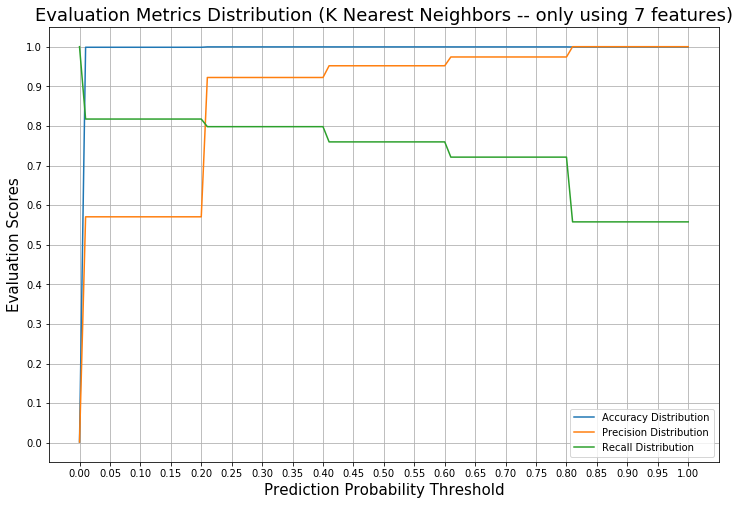

In [43]:
# Let's now try KNN model with only the 7 important features
knn = KNeighborsClassifier(n_jobs = -1)
knn.fit(X_train_scaled[important_features], y_train)
y_pred_proba_knn = knn.predict_proba(X_test_scaled[important_features])
evaluate_score_distribution(y_pred_proba_knn, y_test, "K Nearest Neighbors -- only using 7 features")

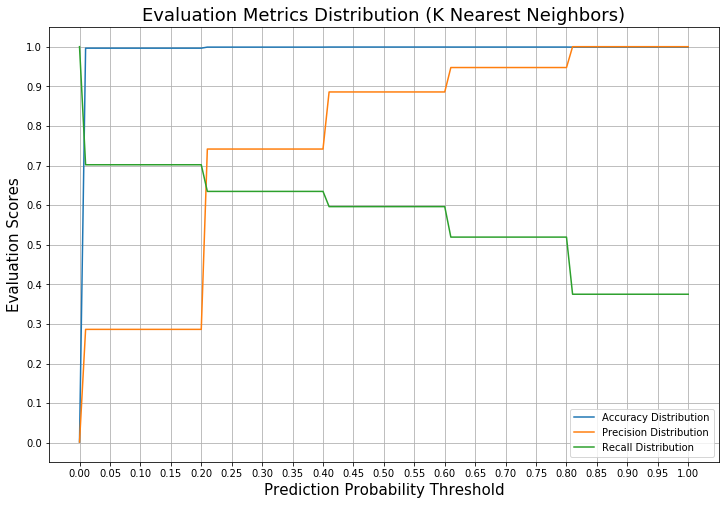

In [44]:
# Let's now see what happens if we use the PCA components of the 7 feature to fit the KNN model
knn_pca = KNeighborsClassifier(n_jobs = -1)
knn_pca.fit(X_train_small_pca, y_train)
y_pred_proba_knn = knn_pca.predict_proba(X_test_small_pca)
evaluate_score_distribution(y_pred_proba_knn, y_test, "K Nearest Neighbors")

In [45]:
X_train_small_pca

array([[ 0.07014861,  0.01433104],
       [ 0.13755176,  0.06452014],
       [-0.07745862,  0.01094982],
       ...,
       [-0.0690374 ,  0.01378354],
       [-0.00137087, -0.08792112],
       [ 0.11868044,  0.04292663]])

The result actually turned out to be worse

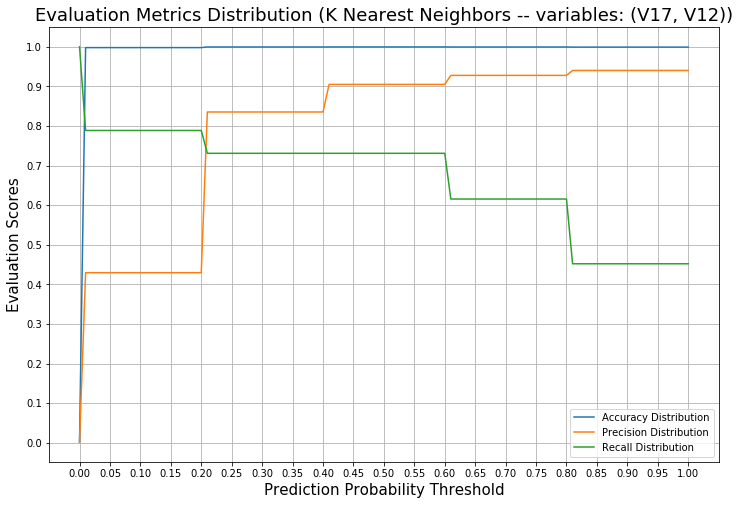

In [46]:
# Lastly, let's only use the two most important features of the data to fit the KNN model
knn = KNeighborsClassifier(n_jobs = -1)
knn.fit(X_train_scaled[["V17", "V12"]], y_train)
y_pred_proba_knn = knn.predict_proba(X_test_scaled[["V17", "V12"]])
evaluate_score_distribution(y_pred_proba_knn, y_test, "K Nearest Neighbors -- variables: (V17, V12)")

The result is slightly worse than the KNN prediction using all variables. But the difference is not so huge. This means that majority of the model's predictive power lies on the first 2 most important features: V17, V12

In [47]:
# Let's plot the boundary graph
def plot_boundary_graph(model, X_train_data, y_train_data, x_var, y_var, model_name, 
                        negative_case_index = negative_case_index_train, 
                        positive_case_index = positive_case_index_train,
                        save_fig = False, figname = None):
    
    cmap_light = ListedColormap(['#AAFFAA', '#FFAAAA'])
    h = 0.02 # step-size in the mesh
    x_min, x_max = X_train_data[[x_var, y_var]].iloc[:,0].min() - .5, X_train_data[[x_var, y_var]].iloc[:,0].max() + .5
    y_min, y_max = X_train_data[[x_var, y_var]].iloc[:,1].min() - .5, X_train_data[[x_var, y_var]].iloc[:,1].max() + .5

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    model.fit(X_train_data[[x_var, y_var]], y_train_data)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])


    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(12, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points

    plt.scatter(x = X_train_data.loc[negative_case_index_train, x_var],
                y = X_train_data.loc[negative_case_index_train, y_var], label = "Normal Cases", s=12, c="b")
    plt.scatter(x = X_train_data.loc[positive_case_index_train, x_var], 
                y = X_train_data.loc[positive_case_index_train, y_var], label = "Fraud Cases", s=12, c="r")

    plt.legend(fontsize = "large")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(x_var, size = 14)
    plt.ylabel(y_var, size = 14)
    plt.title("Decision Boundary Plot for {} Model".format(model_name), size = 18)
    if save_fig == True:
        plt.savefig(figname)
    plt.show()

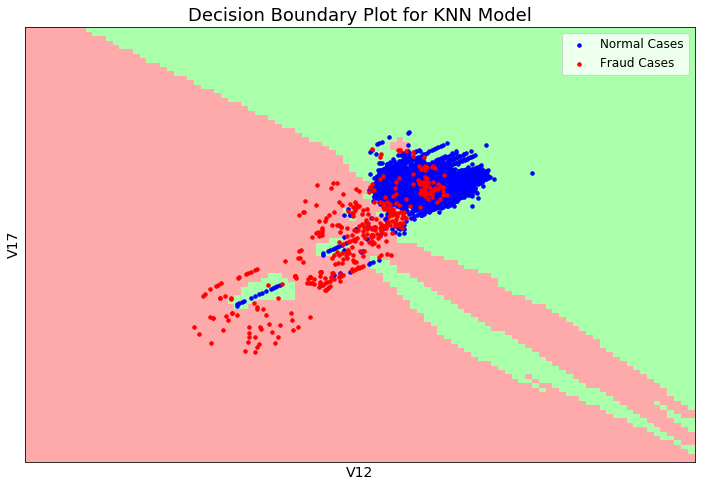

In [48]:
plot_boundary_graph(knn, X_train_scaled, y_train, "V12", "V17", "KNN", save_fig = True, figname = "DBP_KNN.png")

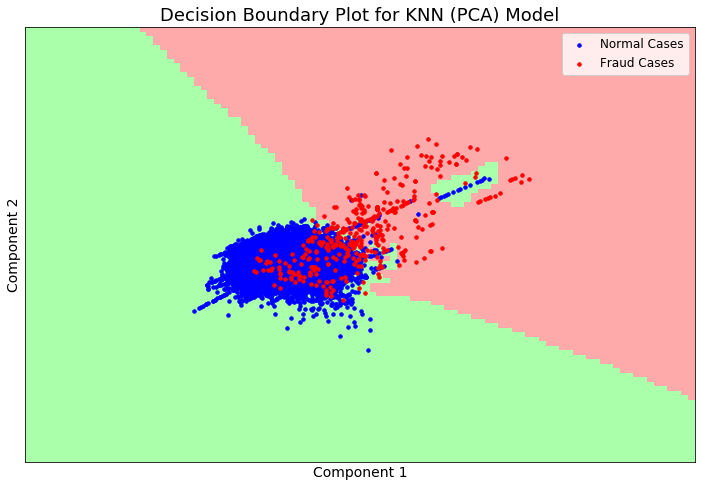

In [49]:
X_train_small_pca_df = pd.DataFrame(X_train_small_pca, columns = ["Component 1", "Component 2"])
plot_boundary_graph(knn_pca, X_train_small_pca_df, y_train, "Component 1", "Component 2", 
                    "KNN (PCA)", save_fig = True, figname = "DBP_KNN_pca.png")

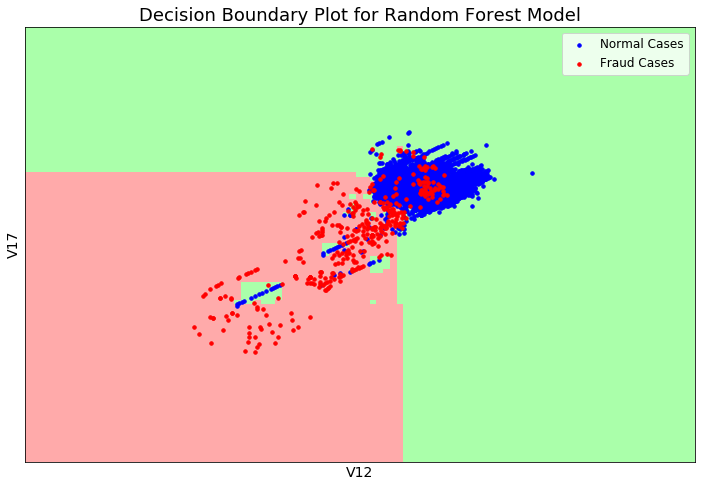

In [50]:
plot_boundary_graph(rf_weighted, X_train_scaled, y_train, "V12", "V17", "Random Forest", save_fig = True,
                   figname = "DBP_RF_weighted.png")

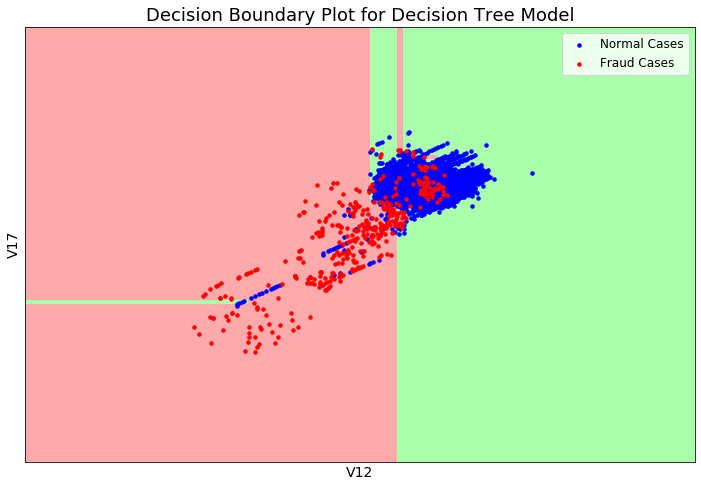

In [51]:
plot_boundary_graph(dt, X_train_scaled, y_train, "V12", "V17", "Decision Tree", save_fig = True,
                   figname = "DBP_DT.png")

Even though Random Forest model has a better evaluation score, maybe the boundary from the KNN model makes more sense

**Before we move to other models, let's focus a little bit on dimensionality reduction again. We will try to see how including different number of raw variables for the dimensionality reduction will impact the model prediction in terms of accuracy, precision and recall**

In [52]:
len(feature_importance.sort_values(ascending=False).index)

30

In [53]:
feature_list_ordered = feature_importance.sort_values(ascending=False).index
pca = PCA(n_components=2, random_state = 0) # dimensionality reduction model

def dimensionality_reduction_eval_graph(model, dim_red_model, feature_list, X_train, y_train, X_test, y_test, 
                                       prediction_threshold, model_name, dim_red_model_name, save_fig = False,
                                       figname = None):
    accuracy_dict = {}
    precision_dict = {}
    recall_dict = {}
    for i in range(2, len(feature_list) + 1): #Initialize it to 2 because we need at least two components

        X_train_transformed_df = pd.DataFrame(dim_red_model.fit_transform(X_train[feature_list[:i]]),
                                      columns = ["Component 1", "Component 2"])
        X_test_transformed_df = pd.DataFrame(dim_red_model.transform(X_test[feature_list[:i]]),
                                     columns = ["Component 1", "Component 2"])

        model.fit(X_train_transformed_df, y_train)
        y_pred_proba = model.predict_proba(X_test_transformed_df)

        y_pred = making_prediction(y_pred_proba, prediction_threshold) # Make a prediction with prediction threshold of 20%

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
    
        accuracy_dict[i] = accuracy
        precision_dict[i] = precision
        recall_dict[i] = recall
        
        print("Iteration for {} variables complete!!".format(i), end = "\r") # print the message to track progress
    # Plot the evaluation scores distribution
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(pd.Series(accuracy_dict), label="Accuracy Distribution")
    ax.plot(pd.Series(precision_dict), label="Precision Distribution")
    ax.plot(pd.Series(recall_dict), label="Recall Distribution")
    plt.xticks(np.arange(2, len(feature_list) + 1))
    plt.yticks(np.arange(0, 1 + 0.1, 0.1))
    plt.xlabel("Number of Feature used in Dimensionality Reduction Method", size = 15)
    plt.ylabel("Evaluation Scores", size = 15)
    plt.grid(axis="both")
    plt.legend(loc="best")
    plt.title("Dimensionality Reducation Evaluation for {} Model ({})".format(model_name, dim_red_model_name), size = 18)
    if save_fig == True:
        plt.savefig("Dim_red_eval_{}_{}.png".format(model_name, dim_red_model_name))
    plt.show()



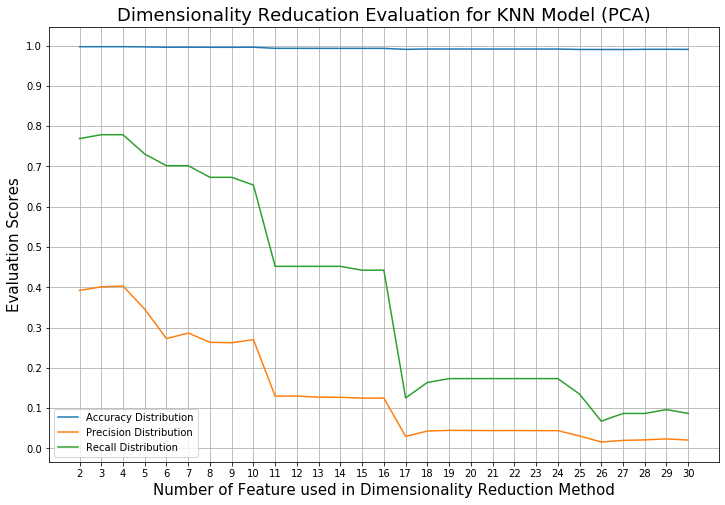

In [54]:
dimensionality_reduction_eval_graph(knn, pca, feature_list_ordered, 
                                    X_train_scaled, y_train, X_test_scaled, y_test, 0.25, "KNN", "PCA", True,
                                   "Dim_Red_Eval_KNN_PCA.png")

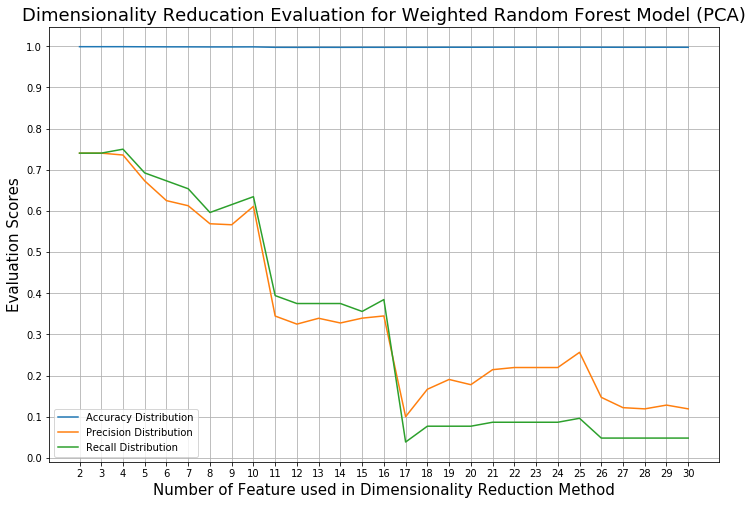

In [55]:
dimensionality_reduction_eval_graph(rf_weighted, pca, feature_list_ordered, 
                                    X_train_scaled, y_train, X_test_scaled, y_test, 0.2, "Weighted Random Forest",
                                   "PCA", True, "Dim_Red_Eval_RF_Weighted_PCA.png")

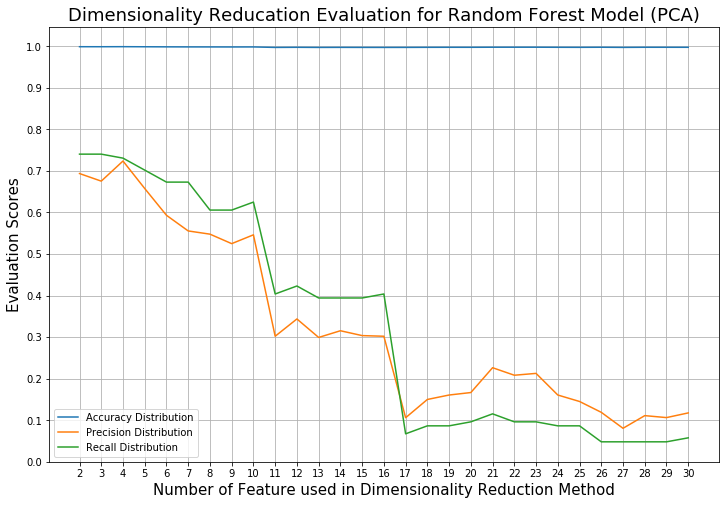

In [56]:
dimensionality_reduction_eval_graph(rf, pca, feature_list_ordered, 
                                    X_train_scaled, y_train, X_test_scaled, y_test, 0.2, "Random Forest",
                                   "PCA", True, "Dim_Red_Eval_RF_PCA.png")

It seems that Dimensionality reduction worsens the random forest method

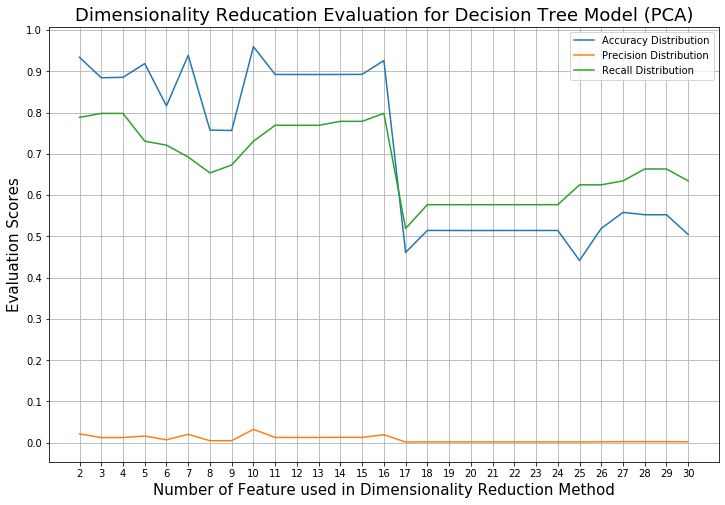

In [57]:
dimensionality_reduction_eval_graph(dt, pca, feature_list_ordered, 
                                    X_train_scaled, y_train, X_test_scaled, y_test, 0.97, "Decision Tree",
                                   "PCA", True, "Dim_Red_Eval_DT_PCA.png")

## Let's now take a look at the Support Vector Machine model

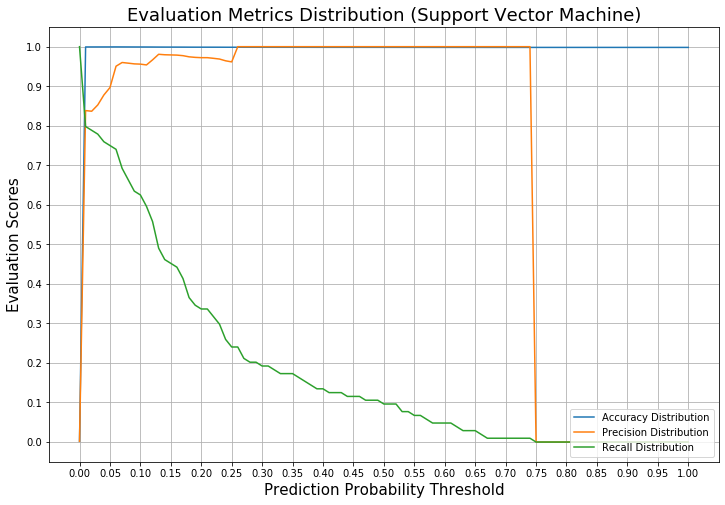

In [58]:
svc = SVC(random_state = 0, probability=True)
svc.fit(X_train_scaled, y_train)
y_pred_proba_svc = svc.predict_proba(X_test_scaled)
evaluate_score_distribution(y_pred_proba_svc, y_test, "Support Vector Machine", True, 
                            "Support Vector Machine Evaluation Distribution.png")

In [ ]:
# Let's see how the evaluation looks if we only use the most important variables
svc.fit(X_train_scaled[["V17", "V12"]], y_train)
y_pred_proba_svc = svc.predict_proba(X_test_scaled[["V17", "V12"]])
evaluate_score_distribution(y_pred_proba_svc, y_test, "Support Vector Machine (V17, V12)", True, 
                            "Support Vector Machine Evaluation Distribution (2 variables).png")

In [ ]:
dimensionality_reduction_eval_graph(svc, pca, feature_list_ordered, 
                                    X_train_scaled, y_train, X_test_scaled, y_test, 0.07, "Support Vector Machine",
                                   "PCA", True, "Dim_Red_Eval_SVC_PCA.png")

In [ ]:
y_pred = svc.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

## Let's take a look at the Naive Bayes model

In [ ]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred_proba_nb = nb.predict_proba(X_test_scaled)
evaluate_score_distribution(y_pred_proba_nb, y_test, "Naive Bayes Model", True, 
                           "Naive Bayes Model Evaluation Distribution.png")

In [ ]:
dimensionality_reduction_eval_graph(nb, pca, feature_list_ordered, 
                                    X_train_scaled, y_train, X_test_scaled, y_test, 0.05, "Naive Bayes",
                                   "PCA", True, "Dim_Red_Eval_Naive_Bayes_PCA.png")